# Week 7 Lab: Plotting Anomalies

Data for lab obtained from Kaggle - [Computer Network Traffic](https://www.kaggle.com/datasets/crawford/computer-network-traffic). 

Computer Network Traffic Data - A ~500K CSV with summary of some real network traffic data from the past. The dataset has ~21K rows and covers 10 local workstation IPs over a three month period. Half of these local IPs were compromised at some point during this period and became members of various botnets.

Content - Each row consists of four columns:

- date: yyyy-mm-dd (from 2006-07-01 through 2006-09-30)
- l_ipn: local IP (coded as an integer from 0-9)
- r_asn: remote ASN (an integer which identifies the remote ISP)
- f: flows (count of connnections for that day)

Reports of "odd" activity or suspicions about a machine's behavior triggered investigations on the following days (although the machine might have been compromised earlier)

Date : IP

08-24 : 1

09-04 : 5

09-18 : 4

09-26 : 3 6

---

##### Importing packages and data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_name = 'cs448b_ipasn.csv'

In [10]:
df_traffic = pd.read_csv(file_name)
df_traffic.head(10)

,date,l_ipn,r_asn,f
0,2006-07-01,0,701,1
1,2006-07-01,0,714,1
2,2006-07-01,0,1239,1
3,2006-07-01,0,1680,1
4,2006-07-01,0,2514,1
5,2006-07-01,0,3320,1
6,2006-07-01,0,3561,13
7,2006-07-01,0,4134,3
8,2006-07-01,0,5617,2
9,2006-07-01,0,6478,1


##### Quick Data Exploration

In [11]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20803 entries, 0 to 20802
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    20803 non-null  object
 1   l_ipn   20803 non-null  int64 
 2   r_asn   20803 non-null  int64 
 3   f       20803 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 650.2+ KB


No nulls meaning no null handling needed.

Data type of date should be converted to datetime.

In [12]:
df_traffic.describe()

,l_ipn,r_asn,f
count,20803.000000,20803.000000,20803.000000
mean,4.228236,12138.320338,93.914243
std,3.278183,9766.324252,5764.995269
min,0.000000,3.000000,1.000000
25%,1.000000,4323.000000,1.000000
50%,4.000000,8764.000000,2.000000
75%,7.000000,17676.000000,8.000000
max,9.000000,40092.000000,784234.000000


First two variables are ignorable as it is on the system. Looking at f or flows, the max is unusually high as we can see that the mean is 2. This means that there exists an anomaly somewhere in the dataset.

##### Data Preparation for Plotting

In [17]:
# Convert date to timestamp first

df_traffic['date'] = pd.to_datetime(df_traffic['date'])
print(df_traffic['date'].dtypes)
df_traffic['date'].head(5)

datetime64[ns]


0   2006-07-01
1   2006-07-01
2   2006-07-01
3   2006-07-01
4   2006-07-01
Name: date, dtype: datetime64[ns]

##### Plot the anomaly

In [20]:
# First, aggregate the total flows by date, the other columns are ignorable since its ip and asn
daily_flows = df_traffic.groupby('date')['f'].sum().reset_index()
daily_flows.columns = ['date', 'total_flows']
daily_flows

,date,total_flows
0,2006-07-01,5058
1,2006-07-02,7437
2,2006-07-03,7248
3,2006-07-04,8280
4,2006-07-05,27189
...,...,...
87,2006-09-26,13963
88,2006-09-27,4143
89,2006-09-28,11149
90,2006-09-29,25281


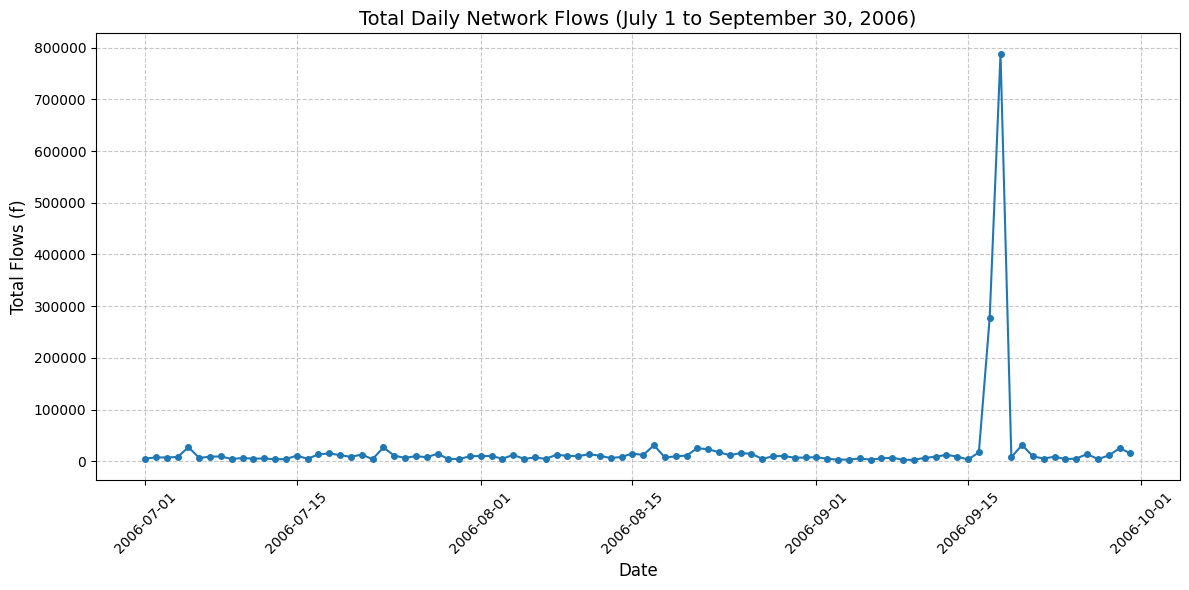

In [21]:
# Plotting the total daily flows
plt.figure(figsize=(12, 6))
plt.plot(daily_flows['date'], daily_flows['total_flows'], marker='o', markersize=4, linestyle='-')
plt.title('Total Daily Network Flows (July 1 to September 30, 2006)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Flows (f)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig('daily_flows_time_series.png')

This chart alone does not tell us the baseline, its important to add the baseline in order to understand what is and is not normal, allowing for faster detection of issues if any arise.

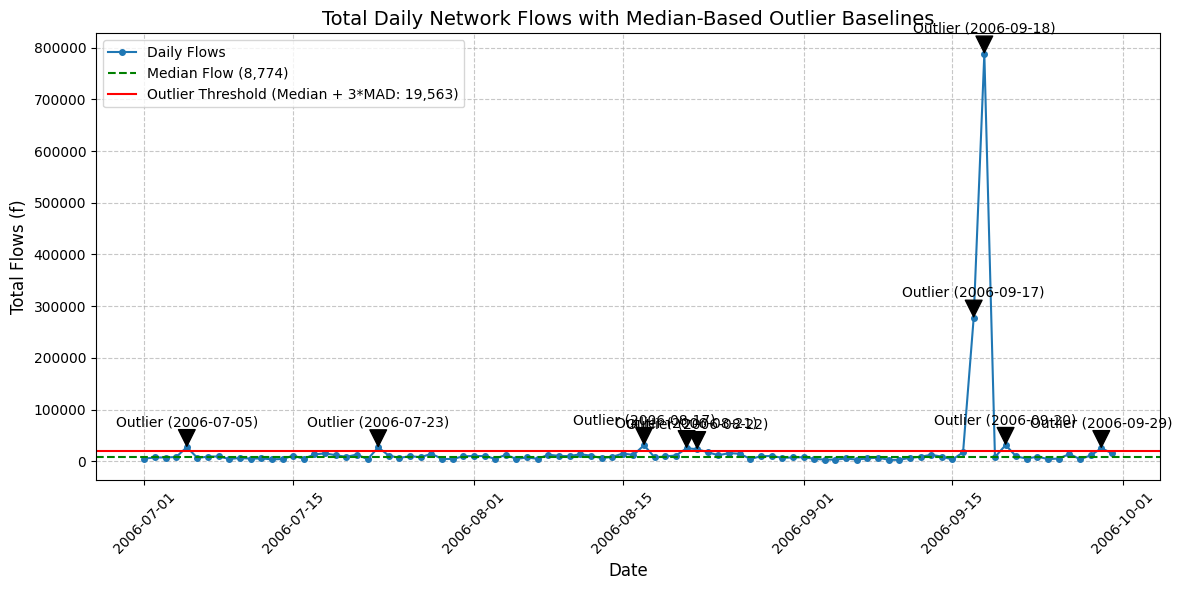

In [25]:
flows = daily_flows['total_flows']

# Calculate baselines based on Median (since mean is not going to be usable due to the high outliers)
median_flow = flows.median()
mad = np.median(np.abs(flows - median_flow)) #mad or short for median absolute deviation haha

# Lets add an outlier threshold here utilizing the median absolute deviation
outlier_threshold = median_flow + 3 * mad

outliers = daily_flows[daily_flows['total_flows'] > outlier_threshold].copy()
outliers['label'] = 'Outlier'

# Plot the time-series data
plt.figure(figsize=(12, 6))
plt.plot(daily_flows['date'], daily_flows['total_flows'], marker='o', markersize=4, linestyle='-', label='Daily Flows')

# Plot the baselines
plt.axhline(median_flow, color='green', linestyle='--', linewidth=1.5, label=f'Median Flow ({median_flow:,.0f})')
plt.axhline(outlier_threshold, color='red', linestyle='-', linewidth=1.5, label=f'Outlier Threshold (Median + 3*MAD: {outlier_threshold:,.0f})')

# Add annotations for outliers
for i, row in outliers.iterrows():
    date_str = row['date'].strftime('%Y-%m-%d')
    plt.annotate(
        f"Outlier ({date_str})",
        (row['date'], row['total_flows']),
        textcoords="offset points",
        xytext=(0, 15),
        ha='center',
        arrowprops=dict(facecolor='black', shrink=0.05, width=0.5)
    )


# Formatting the plot
plt.title('Total Daily Network Flows with Median-Based Outlier Baselines', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Flows (f)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()

# Save the plot
plt.savefig('daily_flows_time_series_with_baselines_&_outliers.png')


Here we can see that with the addition of the baseline, we can say that there are actually more outliers apart from those detected in September 2006. The seemingly normal performance from the previous chart did not tell us which are the outliers on those previous months due to the high stretch on the chart by the outliers for September 2006. This also allowed us to see that there are multiple instances of outliers apart from what we've seen in the mentioned month. 

Assuming that this is an orchestrated attack:

The mentioned dates in the reports where there are odd activities might be a test penetration made. We can see in the charts that in previous months, the flow spiked twice in July which hints at possible test attacks made to see if the system is weak. Come August 2006, we can see that there were multiple attacks around the same number of flows which might be an orchestrated attack to see how the system will react and finally in September, the high flows show that the attack was successful and they were able successfully load the traffic resulting to a higher flow or even a DDoS. Afterwards, there were gaps in the following attacks which indicate a post-testing attack to see if the system security has improved or not.